# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [259]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets.mini_imagenet import MiniImageNet, Split
from datasets.utils import extract_archive

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset Sandbox

In [300]:
from torchvision.transforms import Compose, ToTensor, Resize, Lambda
from torchvision.transforms.functional import InterpolationMode

datadir = "../../data/mini-imagenet"
im_size = 28

transform = ToTensor()
t_transform = Lambda(lambda x: torch.tensor(x))
greyscale = False

trainset = MiniImageNet(
    root=datadir,
    split=Split.TRAIN,
    transform=transform,
    target_transform=t_transform,
    greyscale=greyscale,
    download=True,
)
testset = MiniImageNet(
    root=datadir,
    split=Split.TEST,
    transform=transform,
    target_transform=t_transform,
    greyscale=greyscale,
    download=True,
)
valset = MiniImageNet(
    root=datadir,
    split=Split.VAL,
    transform=transform,
    target_transform=t_transform,
    greyscale=greyscale,
    download=True,
)

# Select single dataset for targeted analysis.
ds = trainset

Computing MD5: /Users/ntraft/Development/data/mini-imagenet/train.tar
MD5 matches: /Users/ntraft/Development/data/mini-imagenet/train.tar
/Users/ntraft/Development/data/mini-imagenet/processed_images/train already exists.
Computing MD5: /Users/ntraft/Development/data/mini-imagenet/test.tar
MD5 matches: /Users/ntraft/Development/data/mini-imagenet/test.tar
/Users/ntraft/Development/data/mini-imagenet/processed_images/test already exists.
Computing MD5: /Users/ntraft/Development/data/mini-imagenet/val.tar
MD5 matches: /Users/ntraft/Development/data/mini-imagenet/val.tar
/Users/ntraft/Development/data/mini-imagenet/processed_images/val already exists.


Training Set statistics:
64 classes
38400 examples


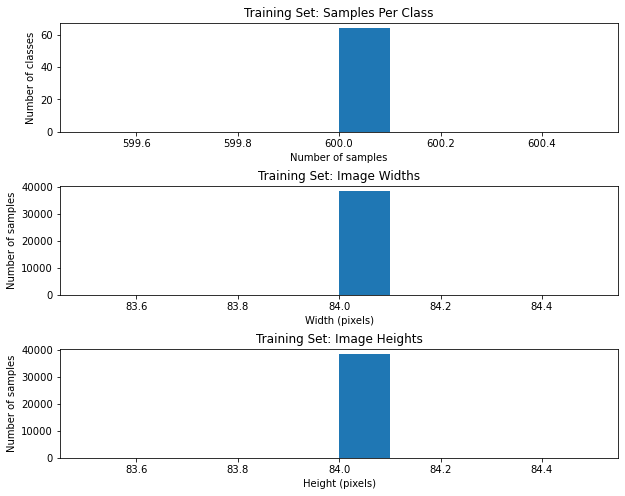

In [304]:
from collections import defaultdict


def show_image_classification_dataset_stats(name, dataset):
    """
    Show statistics for an image classification dataset.
    
    Args:
        name (str): Name of the dataset, like "Training" or "Validation".
        dataset (Dataset): A PyTorch dataset object.
    """
    title = name + " Set"
    print(f"Collecting {title} statistics...", end=" ", flush=True)
    total_size = 0
    class_sizes = []
    widths = []
    heights = []
    class_map = defaultdict(int)
    for img, label in dataset:
        class_map[int(label)] += 1
        if isinstance(img, PIL.Image.Image):
            widths.append(img.width)
            heights.append(img.height)
        else:
            widths.append(img.size()[-1])
            heights.append(img.size()[-2])
    class_sizes = list(class_map.values())
    print("done.")

    print(title, "statistics:")
    print(len(class_map), "classes")
    print(len(dataset), "examples")

    fig, (sax, wax, hax) = plt.subplots(3, figsize=(10, 8), gridspec_kw={"hspace": 0.5})
    sax.hist(class_sizes)
    sax.set_xlabel("Number of samples")
    sax.set_ylabel("Number of classes")
    sax.set_title(f"{title}: Samples Per Class")

    wax.hist(widths)
    wax.set_xlabel("Width (pixels)")
    wax.set_ylabel("Number of samples")
    wax.set_title(f"{title}: Image Widths")

    hax.hist(heights)
    hax.set_xlabel("Height (pixels)")
    hax.set_ylabel("Number of samples")
    hax.set_title(f"{title}: Image Heights")

    
show_image_classification_dataset_stats(str(ds.split), ds)

In [255]:
train_classes = frozenset(trainset.classes.keys())
test_classes = frozenset(testset.classes.keys())
val_classes = frozenset(valset.classes.keys())

print("Overlap between train and test:", len(train_classes & val_classes))
print("Overlap between train and val:", len(train_classes & test_classes))
print("Overlap between val and test:", len(val_classes & test_classes))

Overlap between train and test: 0
Overlap between train and val: 0
Overlap between val and test: 0


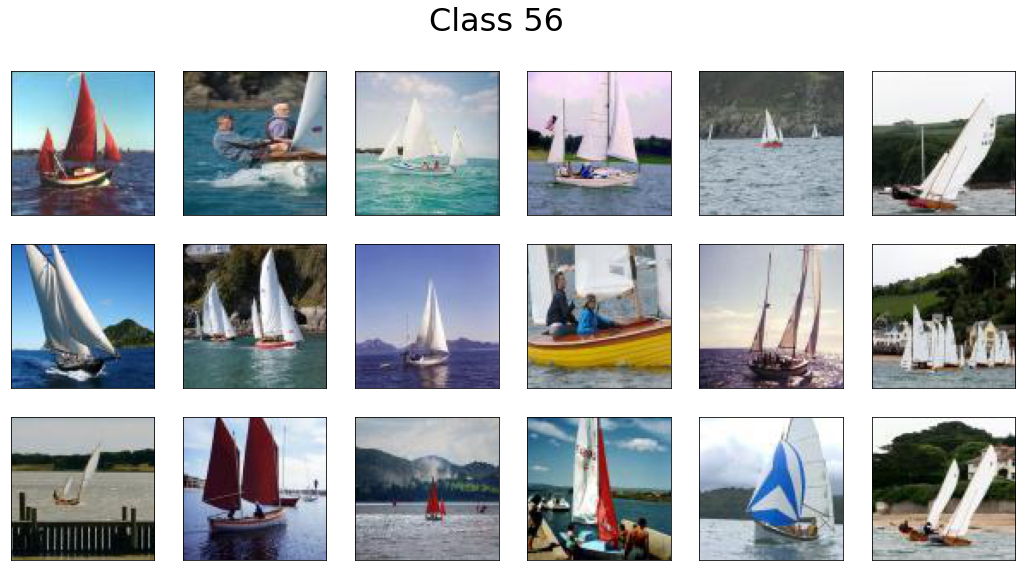

In [306]:
# Randomly sample from a random class and display the samples.
# NOTE: Assumes a dataset of type ClassIndexedDataset.
rows = 3
cols = 6
rng = np.random.default_rng()
indices = rng.choice(rng.choice(ds.class_index), size=rows*cols, replace=False)
samples = [ds[i] for i in indices]

fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
fig.suptitle(f"Class {int(samples[0][1])}", fontsize=32)
for i, (img, _) in enumerate(samples):
    ax = axs[i//cols - 1, i%cols]
    if not isinstance(img, PIL.Image.Image):  # if not image, then must be array-like
        img = img.squeeze()
        if len(img.shape) == 3:
            img = img.permute(1, 2, 0)
    # cmap will be ignored if data is RGB(A) format, so this is compatible with both single- and multi-channel images.
    ax.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Torch Sandbox

In [244]:
from models.anml import RLN

in_channels = 3
out_channels = 256
conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3)

input_shape = (in_channels, 84, 84)
batch = torch.randn(20, *input_shape)
print("batch shape =", batch.shape)

rln = RLN(in_channels, out_channels, num_conv_blocks=4, pool_at_end=True)
print(rln)
x = rln.encoder(batch)
print("RLN on batch =", x.shape)
print("RLN step-by-step:")
x = batch
for i, step in enumerate(rln.encoder):
    x = step(x)
    print(f"Shape after step {i+1}: {x.shape}")

batch shape = torch.Size([20, 3, 84, 84])
RLN(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 256, kernel_size

In [307]:
from datasets.mini_imagenet import create_OML_sampler

sampler, image_shape = create_OML_sampler(root=datadir)

Computing MD5: /Users/ntraft/Development/data/mini-imagenet/train.tar
MD5 matches: /Users/ntraft/Development/data/mini-imagenet/train.tar
/Users/ntraft/Development/data/mini-imagenet/processed_images/train already exists.
Computing MD5: /Users/ntraft/Development/data/mini-imagenet/test.tar
MD5 matches: /Users/ntraft/Development/data/mini-imagenet/test.tar
/Users/ntraft/Development/data/mini-imagenet/processed_images/test already exists.


In [328]:
train_data, train_class, (valid_ims, valid_labels) = sampler.sample_train()

In [330]:
print(train_data[0][0].shape)
print(train_data[0][1].shape)
print(len(train_data))
print(len(train_data * 3))

torch.Size([1, 3, 84, 84])
torch.Size([1])
20
60


# Python Sandbox

In [175]:
sizes = [
    (96 * 11*11*3),
    (256 * 5*5*96),
    (384 * 3*3*256),
    (384 * 3*3*384),
    (256 * 3*3*384),
    (6*6*256 * 4096),
    (4096*4096),
    (4096*1000),
]
print(sizes)
print(np.sum(sizes))

[34848, 614400, 884736, 1327104, 884736, 37748736, 16777216, 4096000]
62367776


In [331]:
[1, 2, 3] * 3

[1, 2, 3, 1, 2, 3, 1, 2, 3]